## Train a Multi-label classification model for furniture type and style
* We will use transfer learning to train a classification model to obtain a feature layer for similarity identification.
* In total, we have build 6 models for evaluation, using transfer learning of VGG16 and InceptionV3

### Dataset
* Hozzu dataset with 90,298 images from 6 categories of furniture across 17 different styles. 
* Source: https://cvml.comp.nus.edu.sg/furniture/index.html
* We have limited the data to 200 images on 15 styles

In [4]:
import os
from pathlib import Path
from imutils import paths
import pandas as pd
import numpy as np
import random
import argparse
import random
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
          
#openCV
import cv2                                

In [ ]:
#Tensor Flow
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16

from tensorflow.keras import callbacks
from tensorflow.keras.applications import xception
from tensorflow.keras.models import Model

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [7]:
labels = ['tables', 'sofas', 'lamps', 'chairs', 'dressers', 'beds']

In [8]:
#get the tag and images from csv
pathroot = "data/"
tags= []
images = []
path = []

for ptype in labels:
    try:
        for files in os.listdir(pathroot+ptype):
            paths = pathroot+ptype+"/"+files
            if os.path.isdir(paths):
                for filename in os.listdir(paths):
                    if filename.endswith(".jpg"):
                        img_path = os.path.join(paths, filename)
                        img_arr = cv2.imread(img_path)
                        img_arr = cv2.resize(img_arr,(100,100))
                        path.append(ptype+"/"+files+"/"+filename)
                        images.append(img_arr)
                        tags.append([ptype,files.lower()])
                    else:
                        continue
    except:
        continue


In [13]:
images,tags = shuffle(images,tags,random_state=20)


### Transfer learning
* Train on a smaller dataset 
* Taking features learned from ImageNet dataset
* Dataset of over 14 million images belonging to 1000 classes


### Multi-label classification
* Multi-label classification is a predictive modeling involves predicting zero or more mutually non-exclusive class labels 
* Multi Label Binarizer: transform the classes to list of binary number using multi label binarizer

In [11]:
mlb = MultiLabelBinarizer()
tags = mlb.fit_transform(tags)

In [16]:
pd.DataFrame(list(mlb.classes_)).to_csv('classes.csv',index=False)

### Allocation of train/test/validation data
* 70% Training 15% Testing 15% Validation

In [17]:
fullsize = len(images)
trainsize = int(fullsize*0.7)
testsize = int(trainsize+fullsize*0.15)

In [18]:
X_train=np.array(images[0:trainsize])
y_train=np.array(tags[0:trainsize])
X_test=np.array(images[trainsize:testsize])
y_test=np.array(tags[trainsize:testsize])
X_val=np.array(images[testsize:])
y_val=np.array(tags[testsize:])

In [19]:
epo = 30
init_lr = 1e-3
bs = 32
image_dims = (100, 100, 3)

### Using Image Data Generator for Image augmentation
*  Flow method: Takes data & label arrays, generates batches of augmented data.

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")


test_datagen = ImageDataGenerator(
    rescale=1./255)


train_generator = train_datagen.flow(X_train, y_train, batch_size=bs)
test_generator = test_datagen.flow(X_test, y_test, batch_size=bs)


### Model Evaluation Overview
#### VGG16 with weights imagenet
* Model 1: VGG16 with all layers freezed, one 256 nodes fully-connected layer
* Model 2: VGG16 with with last 2 blocks trainable and one 256 nodes fully-connected layer
* Model 3: VGG16 with with last 1 blocks trainable and two 128 nodes fully-connected layer

#### InceprionV3 with weights imagenet
* Model 4: InceprionV3 with all layers freezed and one 256 nodes fully-connected layer
* Model 5: InceprionV3 with last 2 blocks trainable and one 256 nodes fully-connected layer
* Model 6: InceprionV3 with last 2 blocks trainable and two 128 nodes fully-connected layer

### Model 1 -  VGG16 with all layers freezed, one 256 nodes fully-connected layer

In [ ]:
from tensorflow.keras.models import Model

base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
predictions = Dense(21, activation='sigmoid')(x)

model0 = Model(inputs=base_model.input, outputs=predictions)

print (model0.summary())

In [ ]:
opt = Adam(lr=init_lr)
model0.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])    

cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
               tf.keras.callbacks.ModelCheckpoint(filepath='model0.{epoch:02d}-{val_loss:.2f}.h5',verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

# Train the model with the new callback

hist0 = model0.fit(train_generator,steps_per_epoch=len(X_train)/bs,
                 epochs=epo,
                 validation_data=test_generator,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289.53125 steps, validate for 63 steps
Epoch 1/30
289/289 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9247
Epoch 00001: saving model to model0.01-0.20.h5
290/289 [==============================] - 529s 2s/step - loss: 0.2352 - accuracy: 0.9247 - val_loss: 0.1980 - val_accuracy: 0.9375
Epoch 2/30
289/289 [============================>.] - ETA: 0s - loss: 0.2036 - accuracy: 0.9335
Epoch 00002: saving model to model0.02-0.19.h5
290/289 [==============================] - 521s 2s/step - loss: 0.2037 - accuracy: 0.9335 - val_loss: 0.1879 - val_accuracy: 0.9412
Epoch 3/30
146/289 [==============>...............] - ETA: 3:26 - loss: 0.1582 - accuracy: 0.9457

In [ ]:
import pickle
model0.save("multilabel0")

with open('trainhist0', 'wb') as file_pi:
      pickle.dump(hist0.history, file_pi)

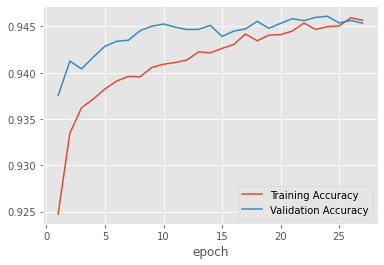

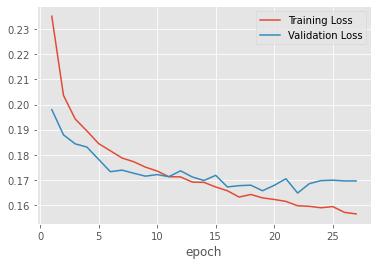

In [148]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
%matplotlib inline

epoch_list = list(range(1, len(hist0.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist0.history['accuracy'], epoch_list, hist0.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

epoch_list = list(range(1, len(hist0.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist0.history['loss'], epoch_list, hist0.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()


In [59]:
val_list = []
val_generator = test_datagen.flow(X_val, y_val, batch_size=bs)

#   Evaluate the model with the test data to get the scores on "real" data.
score0 = model0.evaluate(val_generator, verbose=0)

print('Test loss:', score0[0])
print('Test accuracy:', score0[1])

  ...
    to  
  ['...']
Test loss: 0.16472172264068846
Test accuracy: 0.945883


### Model2 - VGG16 with last 2 blocks trainable and one 256 nodes fully-connected layer

In [ ]:
from tensorflow.keras.models import Model


base_model2 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model2.layers:
    layer.trainable = False


x = base_model2.get_layer('block3_pool').output
x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding='same')(x)
x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding='same')(x)
x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu',padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)

x = Conv2D(filters=512, kernel_size=(2, 2), activation='relu',padding='same')(x)
x = Conv2D(filters=512, kernel_size=(2, 2), activation='relu',padding='same')(x)
x = Conv2D(filters=512, kernel_size=(2, 2), activation='relu',padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
# x = Dropout(0.5)(x)

model2 = Model(inputs=base_model2.input, outputs=predictions)

print (model2.summary())

hist2 = pickle.load(open('trainhist2', "rb"))
model2 = tf.keras.models.load_model("multilabel2")


In [75]:

val_generator = test_datagen.flow(X_val, y_val, batch_size=bs)

#   Evaluate the model with the test data to get the scores on "real" data.
score2 = model2.evaluate(val_generator, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])


  ...
    to  
  ['...']
Test loss: 0.17812441596909176
Test accuracy: 0.9437492


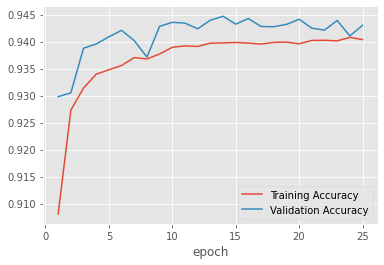

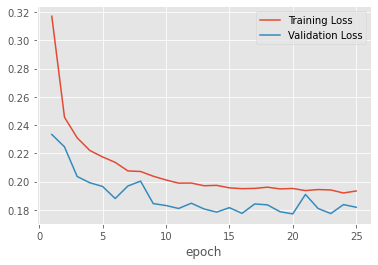

In [150]:

#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist2['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist2['accuracy'], epoch_list, hist2['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

epoch_list = list(range(1, len(hist2['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist2['loss'], epoch_list, hist2['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()

### Model 3 -  VGG16 with last 1 blocks trainable and two 128 nodes fully-connected layer

In [116]:
from tensorflow.keras.models import Model

base_model1 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    
for layer in base_model1.layers[:15]: 
    layer.trainable = False 

for layer in base_model1.layers[15:]: 
    layer.trainable = True

x = base_model1.output
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(21, activation='sigmoid')(x)

model1 = Model(inputs=base_model1.input, outputs=predictions)

print (model1.summary())

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0  

In [117]:
opt = Adam(lr=init_lr)
model1.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])    

In [118]:
cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
               tf.keras.callbacks.ModelCheckpoint(filepath='model1.{epoch:02d}-{val_loss:.2f}.h5',verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]

# Train the model with the new callback

hist1 = model1.fit(train_generator,steps_per_epoch=len(X_train)/bs,
                 epochs=epo,
                 validation_data=test_generator,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289.53125 steps, validate for 63 steps
Epoch 1/30
289/289 [============================>.] - ETA: 1s - loss: 0.2224 - accuracy: 0.9358
Epoch 00002: saving model to model1.02-0.20.h5
290/289 [==============================] - 677s 2s/step - loss: 0.2223 - accuracy: 0.9359 - val_loss: 0.1972 - val_accuracy: 0.9402
Epoch 3/30
289/289 [============================>.] - ETA: 1s - loss: 0.2021 - accuracy: 0.9407
Epoch 00004: saving model to model1.04-0.18.h5
290/289 [==============================] - 677s 2s/step - loss: 0.2021 - accuracy: 0.9407 - val_loss: 0.1843 - val_accuracy: 0.9441
Epoch 5/30
289/289 [============================>.] - ETA: 1s - loss: 0.1711 - accuracy: 0.9465
Epoch 00016: saving model to model1.16-0.17.h5
290/289 [==============================] - 671s 2s/step - loss: 0.1711 - accuracy: 0.9466 - val_loss: 0.1696 - val_accuracy: 0.9465
Epoch 17/30
289/289 [============================>.] - ETA: 1s - loss: 0.169

In [154]:
import pickle
model1.save("multilabel1")
with open('trainhist1', 'wb') as file_pi:
      pickle.dump(hist1.history, file_pi)

INFO:tensorflow:Assets written to: multilabel1/assets


In [ ]:
hist1 = pickle.load(open('trainhist1', "rb"))

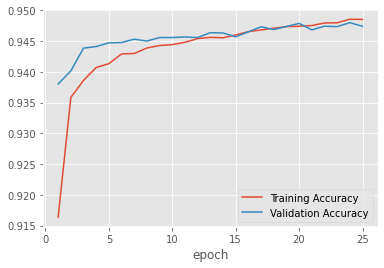

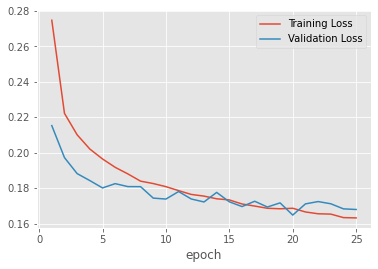

In [149]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist1.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1.history['accuracy'], epoch_list, hist1.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

epoch_list = list(range(1, len(hist1.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist1.history['loss'], epoch_list, hist1.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()

In [120]:
val_generator = test_datagen.flow(X_val, y_val, batch_size=bs)

#   Evaluate the model with the test data to get the scores on "real" data.
score1 = model1.evaluate(val_generator, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

  ...
    to  
  ['...']
Test loss: 0.16946598769180357
Test accuracy: 0.94700986


### Model4 - InceprionV3 with all layers freezed and one 256 nodes fully-connected layer

In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

base_model3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model3.layers: 
    layer.trainable = False 

x = base_model3.output
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
predictions = Dense(21, activation='sigmoid')(x)


model3 = Model(inputs=base_model3.input, outputs=predictions)

print (model3.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 49, 49, 32)   864         input_22[0][0]                   
__________________________________________________________________________________________________
batch_normalization_302 (BatchN (None, 49, 49, 32)   96          conv2d_302[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 49, 49, 32)   0           batch_normalization_302[0][0]    
____________________________________________________________________________________________

In [71]:
opt = Adam(lr=init_lr)
model3.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [72]:

import os

cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
               tf.keras.callbacks.ModelCheckpoint(filepath='model3.{epoch:02d}-{val_loss:.2f}.h5',verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]


hist3 = model3.fit(train_generator,steps_per_epoch=len(X_train)/bs,
                 epochs=epo,
                 validation_data=test_generator,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289.53125 steps, validate for 63 steps
Epoch 1/30
289/289 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9178
Epoch 00001: saving model to model3.01-0.22.h5
290/289 [==============================] - 166s 572ms/step - loss: 0.2629 - accuracy: 0.9178 - val_loss: 0.2229 - val_accuracy: 0.9306
Epoch 2/30
289/289 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9270
Epoch 00002: saving model to model3.02-0.21.h5
290/289 [==============================] - 155s 534ms/step - loss: 0.2277 - accuracy: 0.9270 - val_loss: 0.2126 - val_accuracy: 0.9330
Epoch 3/30
289/289 [============================>.] - ETA: 0s - loss: 0.2173 - accuracy: 0.9295
Epoch 00003: saving model to model3.03-0.21.h5
290/289 [==============================] - 154s 532ms/step - loss: 0.2172 - accuracy: 0.9295 - val_loss: 0.2067 - val_accuracy: 0.9349
Epoch 4/30
289/289 [============================>.] - ETA: 0s - los

In [76]:
import pickle
model3.save("multilabel3")

with open('trainhist3', 'wb') as file_pi:
      pickle.dump(hist3.history, file_pi)

INFO:tensorflow:Assets written to: multilabel3/assets


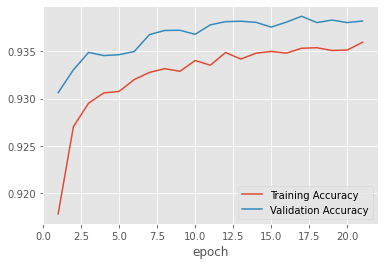

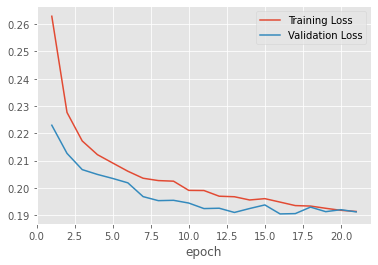

In [151]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist3.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist3.history['accuracy'], epoch_list, hist3.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

epoch_list = list(range(1, len(hist3.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist3.history['loss'], epoch_list, hist3.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()

In [74]:
val_generator = test_datagen.flow(X_val, y_val, batch_size=bs)

#   Evaluate the model with the test data to get the scores on "real" data.
score3 = model3.evaluate(val_generator, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

  ...
    to  
  ['...']
Test loss: 0.1873411266576676
Test accuracy: 0.93789864


### Model5 - InceprionV3 with last 2 blocks trainable and one 256 nodes fully-connected layer

In [83]:
for i,layer in enumerate(base_model4.layers):
    print(i,layer)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff4e80b2450>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff4e80b2810>
2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff4ec0afed0>
3 <tensorflow.python.keras.layers.core.Activation object at 0x7ff4ebf99f10>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff4ec09dfd0>
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff4ebfccd50>
6 <tensorflow.python.keras.layers.core.Activation object at 0x7ff4ebfee690>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff4ebfee790>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff4ebee89d0>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7ff4ebed77d0>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff4ebed7bd0>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff500a5

In [84]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

base_model4 = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model4.layers[:249]: 
    layer.trainable = False 

for layer in base_model4.layers[249:]: 
    layer.trainable = True

x = base_model4.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)


model4 = Model(inputs=base_model4.input, outputs=predictions)

print (model4.summary())

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_584 (Conv2D)             (None, 49, 49, 32)   864         input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_584 (BatchN (None, 49, 49, 32)   96          conv2d_584[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 49, 49, 32)   0           batch_normalization_584[0][0]    
___________________________________________________________________________________________

In [85]:
opt = Adam(lr=init_lr)
model4.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

import os

cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
               tf.keras.callbacks.ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.h5',verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]


hist4 = model4.fit(train_generator,steps_per_epoch=len(X_train)/bs,
                 epochs=epo,
                 validation_data=test_generator,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training



  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289.53125 steps, validate for 63 steps
Epoch 1/30
289/289 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9275
Epoch 00001: saving model to model4.01-0.21.h5
290/289 [==============================] - 221s 763ms/step - loss: 0.2293 - accuracy: 0.9276 - val_loss: 0.2118 - val_accuracy: 0.9388
Epoch 2/30
289/289 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.9381
Epoch 00002: saving model to model4.02-0.18.h5
290/289 [==============================] - 213s 734ms/step - loss: 0.1935 - accuracy: 0.9381 - val_loss: 0.1796 - val_accuracy: 0.9426
Epoch 3/30
289/289 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9410
Epoch 00003: saving model to model4.03-0.18.h5
290/289 [==============================] - 211s 729ms/step - loss: 0.1809 - accuracy: 0.9410 - val_loss: 0.1827 - val_accuracy: 0.9415
Epoch 4/30
289/289 [============================>.] - ETA: 0s - los

In [ ]:
val_generator = test_datagen.flow(X_val, y_val, batch_size=bs)

#   Evaluate the model with the test data to get the scores on "real" data.
score4 = model4.evaluate(val_generator, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])



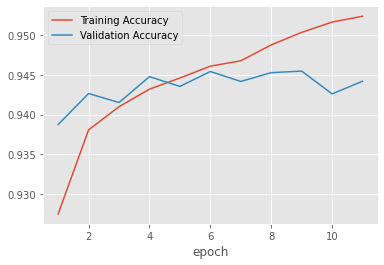

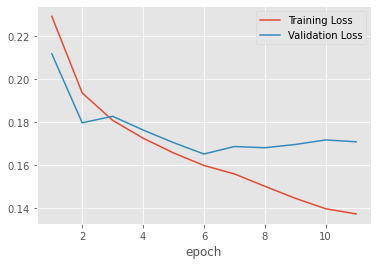

In [152]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist4.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist4.history['accuracy'], epoch_list, hist4.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()

epoch_list = list(range(1, len(hist4.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist4.history['loss'], epoch_list, hist4.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()




In [87]:
import pickle
model4.save("multilabel4")

with open('trainhist4', 'wb') as file_pi:
      pickle.dump(hist4.history, file_pi)

INFO:tensorflow:Assets written to: multilabel4/assets


### Model6 - InceprionV3 with last 2 blocks trainable and two 128 nodes fully-connected layer

In [121]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

base_model6 = InceptionV3(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model6.layers[:249]: 
    layer.trainable = False 

for layer in base_model6.layers[249:]: 
    layer.trainable = True

x = base_model6.output
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(21, activation='sigmoid')(x)

model6 = Model(inputs=base_model6.input, outputs=predictions)

print (model6.summary())

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_678 (Conv2D)             (None, 49, 49, 32)   864         input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_678 (BatchN (None, 49, 49, 32)   96          conv2d_678[0][0]                 
__________________________________________________________________________________________________
activation_658 (Activation)     (None, 49, 49, 32)   0           batch_normalization_678[0][0]    
___________________________________________________________________________________________

In [122]:

opt = Adam(lr=init_lr)
model6.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

import os

cp_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
               tf.keras.callbacks.ModelCheckpoint(filepath='model6.{epoch:02d}-{val_loss:.2f}.h5',verbose=1),
               tf.keras.callbacks.TensorBoard(log_dir='./logs'),]


hist6 = model6.fit(train_generator,steps_per_epoch=len(X_train)/bs,
                 epochs=epo,
                 validation_data=test_generator,
                 callbacks=cp_callback,verbose=1)  # Pass callback to training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289.53125 steps, validate for 63 steps
Epoch 1/30
289/289 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.9187
Epoch 00001: saving model to model6.01-0.24.h5
290/289 [==============================] - 241s 832ms/step - loss: 0.2647 - accuracy: 0.9187 - val_loss: 0.2410 - val_accuracy: 0.9390
Epoch 2/30
289/289 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.9344
Epoch 00002: saving model to model6.02-0.19.h5
290/289 [==============================] - 226s 780ms/step - loss: 0.2207 - accuracy: 0.9344 - val_loss: 0.1921 - val_accuracy: 0.9415
Epoch 3/30
289/289 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9374
Epoch 00003: saving model to model6.03-0.19.h5
290/289 [==============================] - 230s 792ms/step - loss: 0.2079 - accuracy: 0.9374 - val_loss: 0.1874 - val_accuracy: 0.9421
Epoch 4/30
289/289 [============================>.] - ETA: 0s - los

In [ ]:
val_generator = test_datagen.flow(X_val, y_val, batch_size=bs)

#   Evaluate the model with the test data to get the scores on "real" data.
score6 = model6.evaluate(val_generator, verbose=0)
print('Test loss:', score6[0])
print('Test accuracy:', score6[1])

In [155]:
import pickle
model6.save("multilabel6")

with open('trainhist6', 'wb') as file_pi:
      pickle.dump(hist6.history, file_pi)

INFO:tensorflow:Assets written to: multilabel6/assets


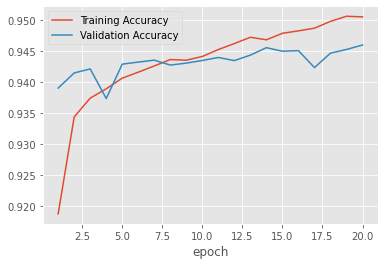

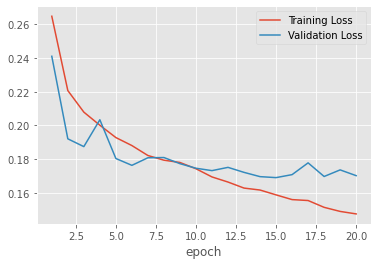

In [153]:
#model6
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist6.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist6.history['accuracy'], epoch_list, hist6.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.xlabel('epoch')
plt.show()


epoch_list = list(range(1, len(hist6.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist6.history['loss'], epoch_list, hist6.history['val_loss'])
plt.legend(('Training Loss', 'Validation Loss'))
plt.xlabel('epoch')
plt.show()


In [127]:
val_dict = {'vgg16_all':[score0[0],score0[1]],
           'vgg16_part':[score2[0],score2[1]],
            'vgg16_twofc':[score1[0],score1[1]],
           'inception_all':[score3[0],score3[1]],
           'inception_part':[score4[0],score4[1]],
           'inception_twofc':[score6[0],score6[1]]}


plotdf = pd.DataFrame.from_dict(val_dict, orient='index',columns = ['val_loss','val_accuracy'])

In [131]:
plotdf.apply(lambda x:round(x,3))

,val_loss,val_accuracy
vgg16_all,0.165,0.946
vgg16_part,0.178,0.944
vgg16_twofc,0.169,0.947
inception_all,0.187,0.938
inception_part,0.169,0.945
inception_twofc,0.171,0.945


<AxesSubplot:>

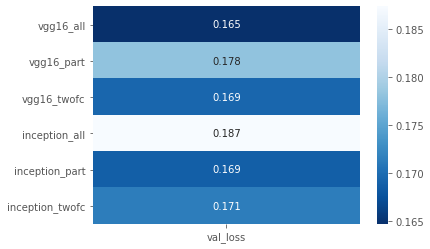

In [146]:
import seaborn as sns
sns.heatmap(pd.DataFrame(plotdf.val_loss), annot=True,fmt=".3f",cmap="Blues_r")

<AxesSubplot:>

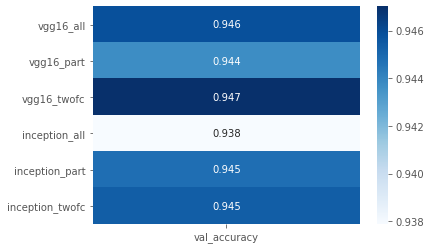

In [145]:
sns.heatmap(pd.DataFrame(plotdf.val_accuracy), annot=True,fmt=".3f",cmap="Blues")